In [1]:
#import sys
#!{sys.executable} -m pip install nltk
#!{sys.executable} -m pip install yellowbrick

In [2]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import re

import sklearn
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# scipy sparse matrix
import scipy
from scipy.sparse import hstack

import matplotlib.pyplot as plt

from string import digits

import os

## Data Preprocessing

In [3]:
def cleanup_URL(s):
    s = s if s else ''

    try:
        tokens = filter(lambda x: x != '', re.split(r'\W', s))        
        tokens = list(tokens)

    except Exception as e:
        tokens = []

    return ''.join(tokens)


def parse_dataset(df):
    df['path'] = list(map(cleanup_URL, df['url']))

    return df

In [4]:
df = pd.read_csv('../../URL_Classification.csv', header=None)
df.columns = ["index", "url", "label"]

num_samples = len(df)
df = df[0:num_samples]

In [5]:
print(f"Parsing {len(df)} rows dataset...")
df = parse_dataset(df)

print("Done")

Parsing 1562978 rows dataset...
Done


In [6]:
df.head(15)

,index,url,label,path
0,1,http://www.liquidgeneration.com/,Adult,httpwwwliquidgenerationcom
1,2,http://www.onlineanime.org/,Adult,httpwwwonlineanimeorg
2,3,http://www.ceres.dti.ne.jp/~nekoi/senno/senfir...,Adult,httpwwwceresdtinejpnekoisennosenfirsthtml
3,4,http://www.galeon.com/kmh/,Adult,httpwwwgaleoncomkmh
4,5,http://www.fanworkrecs.com/,Adult,httpwwwfanworkrecscom
5,6,http://www.animehouse.com/,Adult,httpwwwanimehousecom
6,7,http://www2.117.ne.jp/~mb1996ax/enadc.html,Adult,httpwww2117nejpmb1996axenadchtml
7,8,http://archive.rhps.org/fritters/yui/index.html,Adult,httparchiverhpsorgfrittersyuiindexhtml
8,9,http://www.freecartoonsex.com/,Adult,httpwwwfreecartoonsexcom
9,10,http://www.cutepet.org/,Adult,httpwwwcutepetorg


## Labeling

In [7]:
unique_labels = list(set(df['label']))
unique_labels.sort()

label2idx = {unique_labels[k] : k for k in range(len(unique_labels))}
idx2label = {i: k for k, i in label2idx.items()}

df['label'] = df['label'].map(label2idx)

In [8]:
label2idx

{'Adult': 0,
 'Arts': 1,
 'Business': 2,
 'Computers': 3,
 'Games': 4,
 'Health': 5,
 'Home': 6,
 'Kids': 7,
 'News': 8,
 'Recreation': 9,
 'Reference': 10,
 'Science': 11,
 'Shopping': 12,
 'Society': 13,
 'Sports': 14}

## Bag of Words

In [9]:
bow_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(5, 5))

In [10]:
X = bow_vectorizer.fit_transform(df['path'])
y = df['label'].values

X, y = shuffle(X, y, random_state=67)

X.shape, y.shape

((1562978, 2434978), (1562978,))

## SGDClassifier

In [11]:
clf = sklearn.linear_model.SGDClassifier(loss='hinge',
                                         class_weight='balanced',
                                         alpha=1.3945578080387041e-06,
                                         max_iter=1000,
                                         verbose=0,
                                         n_jobs=-1,
                                         n_iter_no_change=60,
                                         average=32)

### Split train/test set to evaluate result

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123456)

In [13]:
clf.fit(X_train, y_train)

SGDClassifier(alpha=1.3945578080387041e-06, average=32, class_weight='balanced',
              n_iter_no_change=60, n_jobs=-1)

In [14]:
print(classification_report(y_train, clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     23791
           1       0.96      0.93      0.94    169876
           2       0.91      0.90      0.90    160883
           3       0.92      0.93      0.92     79000
           4       0.93      0.96      0.94     37835
           5       0.93      0.98      0.95     40307
           6       0.94      0.99      0.97     19006
           7       0.87      0.91      0.89     30834
           8       0.78      0.99      0.87      6062
           9       0.93      0.95      0.94     71415
          10       0.90      0.96      0.93     38852
          11       0.95      0.93      0.94     73731
          12       0.86      0.91      0.89     63984
          13       0.96      0.92      0.94    163561
          14       0.96      0.98      0.97     68058

    accuracy                           0.93   1047195
   macro avg       0.92      0.95      0.93   1047195
weighted avg       0.93   

In [15]:
y_pred = clf.predict(X_test)

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.68      0.70     11534
           1       0.65      0.65      0.65     83964
           2       0.57      0.61      0.59     79294
           3       0.54      0.57      0.55     38962
           4       0.65      0.59      0.62     18642
           5       0.59      0.59      0.59     19790
           6       0.68      0.59      0.63      9263
           7       0.44      0.37      0.41     15348
           8       0.36      0.42      0.39      2927
           9       0.52      0.52      0.52     35171
          10       0.57      0.60      0.58     19395
          11       0.62      0.58      0.60     36555
          12       0.41      0.45      0.43     31286
          13       0.67      0.64      0.65     80382
          14       0.70      0.71      0.70     33270

    accuracy                           0.60    515783
   macro avg       0.58      0.57      0.57    515783
weighted avg       0.60   

normalize true / rows


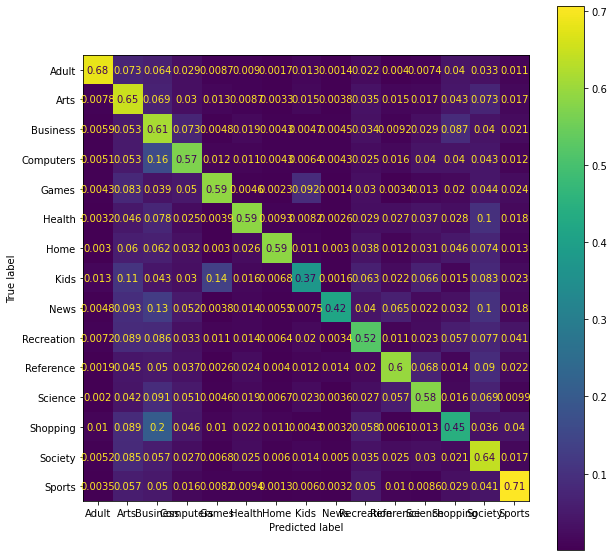

normalize pred / cols


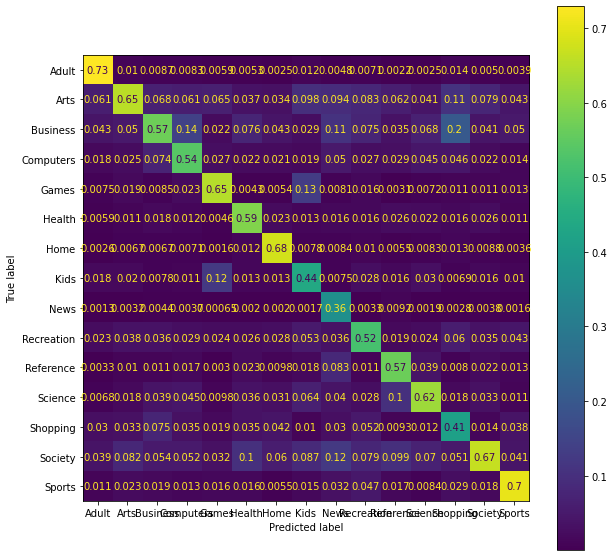

normalize all / cols + rows


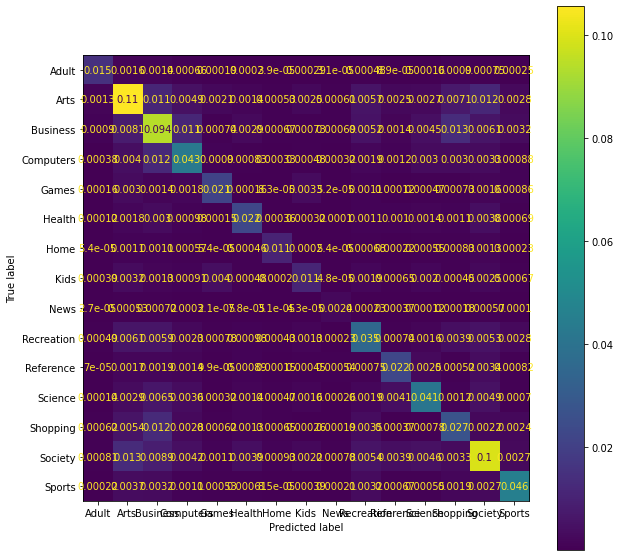

do not normalize


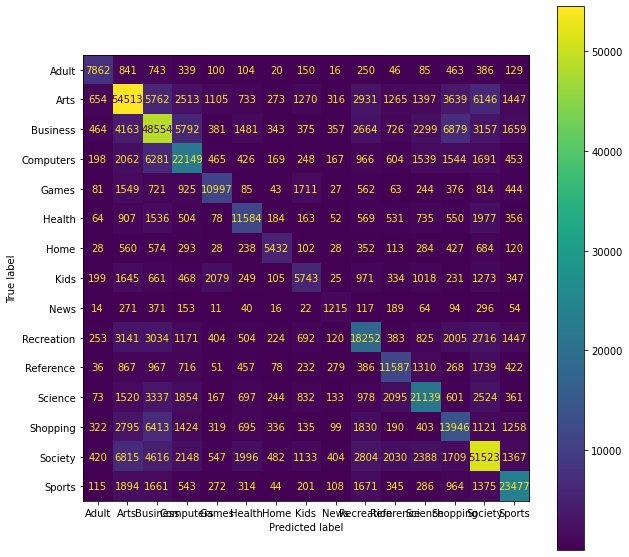

In [17]:
cm_true = confusion_matrix(y_test, y_pred, normalize='true', labels=[k for k in idx2label]) 
cm_pred = confusion_matrix(y_test, y_pred, normalize='pred', labels=[k for k in idx2label])
cm_all = confusion_matrix(y_test, y_pred, normalize='all', labels=[k for k in idx2label])
cm_none = confusion_matrix(y_test, y_pred, labels=[k for k in idx2label])


disp_true = ConfusionMatrixDisplay(confusion_matrix=cm_true, display_labels=unique_labels)
disp_pred = ConfusionMatrixDisplay(confusion_matrix=cm_pred, display_labels=unique_labels)
disp_all = ConfusionMatrixDisplay(confusion_matrix=cm_all, display_labels=unique_labels)
disp_none = ConfusionMatrixDisplay(confusion_matrix=cm_none, display_labels=unique_labels)

fig, ax = plt.subplots(figsize=(10, 10))
print('normalize true / rows')
disp_true.plot(include_values=True, ax=ax)
plt.show()

fig, bx = plt.subplots(figsize=(10, 10))
print('normalize pred / cols')
disp_pred.plot(include_values=True, ax=bx)
plt.show()

fig, cx = plt.subplots(figsize=(10, 10))
print('normalize all / cols + rows')
disp_all.plot(include_values=True, ax=cx)
plt.show()

fig, dx = plt.subplots(figsize=(10, 10))
print('do not normalize')
disp_none.plot(include_values=True, ax=dx)
plt.show()

In [ ]:
cvs = cross_val_score(clf, X, y, cv=3, scoring='f1_macro')
print(f'Mean {np.mean(cvs):.5f} \tVar {np.var(cvs):.5f}')